# Importing packages 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

import scipy.stats
import random
from fitter import Fitter
import attr

from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import OrderedDict
# Local package
import MNL_estimation as MNL

import pylogit as pl

# Define the necessary functions

In [12]:


def CreateChoiceDF(*argv):
    """
    Function that generates a dataframe object for all desired variables.
    Input:
    ------
    Series of tuples showing the variable and desired variable name
    in the output dataframe.
    Example, if the user desired to created a dataframe with 2 variables,
    the function should be called as follows:
    df = CreateChoiceDF(("var1_name", var1),("var2_name", var2))  
    Output:
    -------
    DataFrame object
    """
    data_dict = dict()
    for arg in argv:
        data_dict[arg[0]] = arg[1]
    sample_data = pd.DataFrame(data_dict)
    return sample_data

def SimulateChoices(data,
                    ind_variables,
                    alt_var_vars,
                    number_alts,
                    specification,
                    names,
                    initial_betas):
    """
    Function to simulate choices from input dataset based on
    specified utility equation.
    Input:
    ------
    data: DataFrame
        dataset to be used to simulate choices
    ind_variables: list of strings.
        Each element should be a column heading in `wide_data` that denotes a
        variable that varies across observations but not across alternatives.
    alt_var_vars:    dict.
        Each key should be a string that will be a column heading of the
        returned, long format dataframe. Each value should be a dictionary
        where the inner key is the alternative id and the value is the column
        heading in wide data that specifies the value of the outer key for the
        associated alternative. The variables denoted by the outer key should
        vary across individuals and across some or all alternatives.
    number_alts: int
        Number of alternatives considered
    specification: OrderedDict.
        Keys are a proper subset of the columns in `long_form_df`. Values are
        either a list or a single string, `all_diff` or `all_same`. If a list,
        the elements should be:
            1) single objects that are within the alternative ID column of
               `long_form_df`
            2) lists of objects that are within the alternative ID column of
               `long_form_df`. For each single object in the list, a unique
                column will be created (i.e. there will be a unique
                coefficient for that variable in the corresponding utility
                equation of the corresponding alternative). For lists within
                the `specification_dict` values, a single column will be
                created for all the alternatives within iterable (i.e. there
                will be one common coefficient for the variables in the
                iterable).
    names : OrderedDict or None, optional.
        Should have the same keys as `specification`. For each key:

            - if the corresponding value in `specification` is
              "all_same", then there should be a single string as the value
              in names.
            - if the corresponding value in `specification` is "all_diff",
              then there should be a list of strings as the value in names.
              There should be one string in the value in names for each
              possible alternative.
            - if the corresponding value in `specification` is a list, then
              there should be a list of strings as the value in names.
              There should be one string the value in names per item in the
              value in `specification`.
    initial_betas: list
        List with initial betas for each of the variables entering the model.
        List elements should be entered in the right order.   
    Output:
    -------
    DataFrame with an additional simulated choice column based on the specified
    utility functions.
   """

    choice_var = 'choice'
    custom_alt_id = "alternative_id"
    obs_id_column = "custom_id"

    # Adding a Choice Variable Column
    data[choice_var] = np.random.randint(1, high=number_alts+1, size=data.shape[0])
    availability_variables = dict()

    # Adding availability variables and specifying alternative availability numbers
    for alt in np.arange(1, number_alts+1, 1):
        data['AV_' + str(alt)] = 1
        availability_variables[alt] = 'AV_' + str(alt)

    # Specifying the Individual Variables
    ind_variables = ind_variables

    alt_varying_variables = alt_var_vars
    # Specifying the column heading for the alternative id column in the
    # long format dataset
    custom_alt_id = "alternative_id"
    obs_id_column = "custom_id"
    sample_data[obs_id_column] = np.arange(sample_data.shape[0],
                                           dtype=int) + 1

    # Create a variable recording the choice column

    long_data = pl.convert_wide_to_long(wide_data=sample_data,
                                        ind_vars=ind_variables,
                                        alt_specific_vars=alt_varying_variables,
                                        availability_vars=availability_variables,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_var,
                                        new_alt_id_name=custom_alt_id)

    # Functions to generate the probabilities for each alternative
    design_matrix, names = MNL.create_design_matrix(long_data,specification, names, custom_alt_id)
    mapping_matrix = MNL.create_mapping_matrix(long_data, obs_id_column)
    probabilities = MNL.calculate_probabilities(initial_betas, design_matrix, mapping_matrix)


    # Run through the number of alternatives to generate a dictionary
    # with probabilities for each alternative
    probs = dict()
    for alt in np.arange(1, number_alts + 1, 1):
        probs[alt] = probabilities[long_data['alternative_id']==alt]
    df_probs = pd.DataFrame(probs)
    probs_sum = dict()
    for alt in np.arange(1, number_alts, 1):
        probs_sum[alt] = np.array(df_probs.iloc[:,:alt].sum(axis=1))

    # probs_sum[3]=probs[3]

    u = np.random.uniform(size=len(long_data['custom_id'].unique()))
    choices = dict()
    for alt in np.arange(1, number_alts, 1):
        choices[alt] = np.where(u<=probs_sum[alt], alt, 0)
    choices[number_alts] = np.where(u>probs_sum[number_alts - 1], number_alts, 0)
    data[choice_var] = sum(choices.values())
    # long_data.choice = np.column_stack(list(choices.values())).ravel()
    return data

# Example Application 

## Reading and Cleaning Data 

In [13]:
BATS = pd.read_excel('dataModelWide02.xlsx')

In [28]:
# Cleaning Data, dropping unreported values and 
# assigning random income within each respective range
BATS_IND = BATS.drop_duplicates(subset='personID').reset_index(drop=True)

BATS_IND = BATS_IND[(BATS_IND.HHINCOME!=98)&(BATS_IND.HHINCOME!=99)]
BATS_IND = BATS_IND[(BATS_IND.HHBICYC!=98)&(BATS_IND.HHBICYC!=99)]
BATS_IND = BATS_IND[(BATS_IND.HHMCYCLE!=98)&(BATS_IND.HHMCYCLE!=99)]
BATS_IND = BATS_IND[(BATS_IND.DWELLTYP!=998)&(BATS_IND.DWELLTYP!=999)]
BATS_IND = BATS_IND[(BATS_IND.HHPHONES!=98)&(BATS_IND.HHPHONES!=99)]
BATS_IND = BATS_IND[(BATS_IND.INTERNM1!=8)&(BATS_IND.INTERNM1!=9)]
BATS_IND = BATS_IND[(BATS_IND.INTERNM2!=8)&(BATS_IND.INTERNM2!=9)]
BATS_IND = BATS_IND[(BATS_IND.GENDER!=8)&(BATS_IND.GENDER!=9)]
BATS_IND = BATS_IND[(BATS_IND.AGE!=998)&(BATS_IND.AGE!=999)&(BATS_IND.AGE!=997)]
BATS_IND = BATS_IND[(BATS_IND.NUMJOBS!=98)&(BATS_IND.NUMJOBS!=99)]
BATS_IND = BATS_IND[(BATS_IND.EMPSTATU!=8)&(BATS_IND.EMPSTATU!=9)]
BATS_IND = BATS_IND[(BATS_IND.EMPTYPE!=8)&(BATS_IND.EMPTYPE!=9)]
BATS_IND = BATS_IND[(BATS_IND.SCHAMT!=8)&(BATS_IND.SCHAMT!=9)]
BATS_IND = BATS_IND[(BATS_IND.SCHTYP!=998)&(BATS_IND.SCHTYP!=999)]
BATS_IND = BATS_IND[(BATS_IND.DISTYPE!=998)&(BATS_IND.DISTYPE!=999)]
BATS_IND = BATS_IND[(BATS_IND.ETHNIC!=998)&(BATS_IND.ETHNIC!=999)].reset_index(drop=True)

BATS_IND['income'] = BATS_IND.HHINCOME.apply(
                                            lambda x: random.randrange(0,15000,10)if x==1 else
                                                     (random.randrange(10000,15000,10)if x==2 else 
                                                     (random.randrange(15000,20000,10)if x==3 else
                                                     (random.randrange(20000,25000,10)if x==4 else
                                                     (random.randrange(25000,30000,10)if x==5 else
                                                     (random.randrange(30000,35000,10)if x==6 else
                                                     (random.randrange(35000,40000,10)if x==7 else
                                                     (random.randrange(40000,45000,10)if x==8 else
                                                     (random.randrange(45000,50000,10)if x==9 else
                                                     (random.randrange(50000,60000,10)if x==10 else
                                                     (random.randrange(60000,75000,10)if x==11 else
                                                     (random.randrange(75000,100000,10)if x==12 else
                                                     (random.randrange(100000,125000,10)if x==13 else
                                                     (random.randrange(125000,150000,10)if x==14 else
                                                      random.randrange(150000,250000,10)))))))))))))))
BATS_IND = BATS_IND[BATS_IND['income']!= 0]

## Generate Variables 

In [29]:
age = BATS_IND.AGE.values
income = BATS_IND.income.values
income_div = income/100000
tt_DA = np.abs(np.sqrt(age) + 500000/income + np.random.normal(0, 1, BATS_IND.shape[0]))
tt_TR = np.abs(2.5*age + 40000/np.sqrt(income) + np.random.normal(0, 1, BATS_IND.shape[0]))
tt_BS = np.abs(1.5*age + 500000/income + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_DA = np.abs(10*tt_DA + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_TR = np.abs(tt_TR/100 + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_BS = np.abs(0.25*tt_BS + np.random.normal(0, 1, BATS_IND.shape[0]))

## Generate dataset based on assumed Causal Graph

In [30]:
sample_data = CreateChoiceDF(("age", age),
                             ("income", income_div),
                             ("tt_DA", tt_DA),
                             ("tt_BS", tt_BS),
                             ("tt_TR", tt_TR),
                             ("cost_DA", cost_DA),
                             ("cost_BS", cost_BS),
                             ("cost_TR", cost_TR)
                            )

## Setting Alternative Varying Variables

In [31]:
ind_variables = ['income','age']
alt_varying_variables = {'Cost': dict([(1, 'cost_TR'),
                                       (2, 'cost_DA'),
                                       (3, 'cost_BS')]),
                         'Travel_Time': dict([(1, 'tt_TR'),
                                              (2, 'tt_DA'),
                                              (3, 'tt_BS')]),
                        }

## Setting the specification fo the utility equation

In [32]:
model_specification = OrderedDict()
model_names = OrderedDict()

model_specification['intercept'] = [2,3] ## Which utility equation does the variable enter
model_names['intercept'] = ['ASC_DA', 'ASC_BS']

model_specification['income'] = [1,2,3] ## Which utility equation does the variable enter
model_names['income'] = ['income_TR', 'income_DA', 'income_BS']

model_specification['age'] = [1,2,3] ## Which utility equation does the variable enter
model_names['age'] = ['age_TR', 'age_DA', 'age_BS']

model_specification['Cost'] = [1,2,3] ## Which utility equation does the variable enter
model_names['Cost'] = ['cost_TR', 'cost_DA', 'cost_BS']

model_specification['Travel_Time'] = [1,2,3] ## Which utility equation does the variable enter
model_names['Travel_Time'] = ['tt_TR', 'tt_DA', 'tt_BS']

## Intial model parameters

In [33]:
initial_betas= [2, 3, # ASC
                -1, .5, -.2,  # income
                .8, .3, .5, # age
                -.4, -.2, -.04, # cost
                -.5, -.05, -.04, # travel time
                ]

# Simulate Choices 

In [34]:
data = SimulateChoices(sample_data,
                       ind_variables,
                       alt_varying_variables,
                       3,
                       model_specification,
                       model_names,
                       initial_betas)

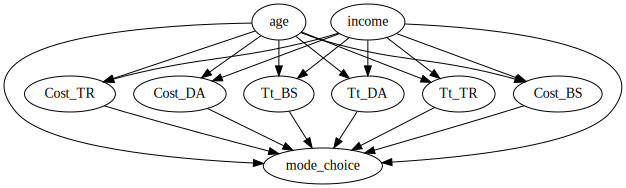

In [39]:
causal_model = StructuralCausalModel({
    "age": lambda     n_samples: data.age,
    "income": lambda  n_samples: data.income,
    "Tt_DA": lambda age,income, n_samples: data.tt_DA,
    "Tt_BS": lambda age,income, n_samples: data.tt_BS,
    "Tt_TR": lambda age,income, n_samples: data.tt_TR,
    "Cost_DA": lambda age,income, n_samples: data.cost_DA,
    "Cost_BS": lambda age,income, n_samples: data.cost_BS,
    "Cost_TR": lambda age,income, n_samples: data.cost_TR,
    "mode_choice": lambda age,income,Tt_DA,Tt_BS,Tt_TR,Cost_DA,Cost_BS,Cost_TR, n_samples: data.choice
})
causal_model.cgm.draw()